# Import lib

In [9]:
import pandas as pd

from utils import *
from utils import eda_describe, select_data, impute

# Dataset

## raw input

Raw data

In [10]:
# Load and preprocess
# Load
df = pd.read_csv(r'Dataset/dataset.csv')

# Preprocess
df = df[df['company'].isna()==False]
df.drop(columns = ['platform'], inplace=True)

    # Standardize cost
df[['cogs', 'sales_cost', 'admin_cost']] = df[['cogs', 'sales_cost', 'admin_cost']].apply(
    lambda x: abs(x)
)

    # for_own/gov_own -> dummy var (0 or null -> 0; else -> 1)
df[['for_own', 'gov_own']] = df[['for_own', 'gov_own']].fillna(0)
df['for_own'] = df['for_own'].apply(
    lambda x: 0 if x == 0  else 1)
df['gov_own'] = df['gov_own'].apply(
    lambda x: 0 if x == 0  else 1)

    ## ----- Data prescaled ------- ##
df_raw = df.copy()
df_raw.sort_values(by=['company', 'year'], ascending=True, inplace=True)

To better reflect the value of the data, I scaled all vars based on GDP deflator of year 2010 for all vars (except percentage based vars)

In [11]:
# Scaled data to GDP deflator 2010
df_raw_deflator = df_raw.copy()
df_raw_deflator['deflator_scaled'] = df_raw_deflator['year'].map(
    {2015: 0.71, 2016: 0.70, 2017: 0.67,2018: 0.65,2019: 0.63,2020: 0.62,2021: 0.60,2022: 0.58,2023: 0.57,2024: 0.54})

# Scaled
df_raw_deflator[['ebitda', 'revenue', 'cogs', 'sales_cost',
       'admin_cost', 'net_op_profit', 'short_receive', 'in_stock',
       'invest_nav', 'long_receive', 'long_liability', 'short_liability',
       'cash', 'fixed_asset', 'other_long_asset', 'cwip', 'other_short_asset',
       'long_invest', 'equity_fund', 'other_fund', 'market_cap', 'ev']] = \
df_raw_deflator[['ebitda', 'revenue', 'cogs', 'sales_cost',
       'admin_cost', 'net_op_profit', 'short_receive', 'in_stock',
       'invest_nav', 'long_receive', 'long_liability', 'short_liability',
       'cash', 'fixed_asset', 'other_long_asset', 'cwip', 'other_short_asset',
       'long_invest', 'equity_fund', 'other_fund', 'market_cap', 'ev']].apply(lambda x:
                                                                        x*df_raw_deflator['deflator_scaled'])

# drop the scaler
df_raw_deflator.drop(columns='deflator_scaled', inplace=True)

Comment:
- Target variable (outcome): ebitda dummy, revenue, roa, roe, roic, roce, value_added (see vars_used.txt file for details)
- As raw input, all the rest vars are used as features

## target var eda

REGRESSION PROBLEM

REVENUE:
+ After applying log, skew and kurtosis of revenue decreases -> good
+ The distribution of revenue turns into normal dist

-------- Original -----------


count          mean           std       min           25%  \
revenue  18761.0  1.960506e+12  1.098396e+13  726643.1  7.247256e+10   

                  50%           75%           max  skewness  kurtosis  
revenue  2.417693e+11  9.353446e+11  3.810080e+14   18.2543  423.6201

------- Log scaled ------------


count     mean     std      min      25%      50%      75%  \
revenue  18761.0  26.2645  2.0033  13.4962  25.0065  26.2112  27.5642   

             max  skewness  kurtosis  
revenue  33.5738   -0.1356    0.8246

<Axes: title={'center': 'Revenue Log'}, xlabel='revenue', ylabel='Count'>

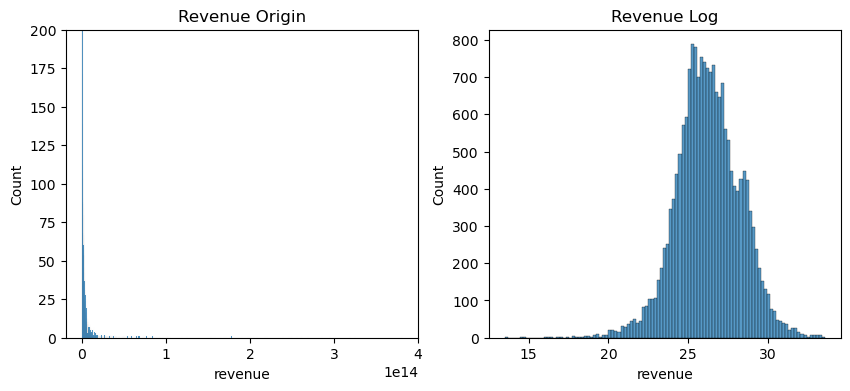

In [12]:
# Revenue
df_rev = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit', 'roa','roe', 'roic', 'roce'])
  # Filter for rev > 0
df_rev = df_rev[df_rev['revenue']>0]
print('-------- Original -----------')
display(eda_describe(df_rev.drop(columns='year'))[:1])
print('------- Log scaled ------------')
df_rev_log = df_rev.copy()
df_rev_log['revenue'] = df_rev_log['revenue'].apply(lambda x: np.log(x))
display(eda_describe(df_rev_log.drop(columns='year'))[:1])
    # Chart
f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title('Revenue Origin')
ax[0].set_ylim(top=200)
sns.histplot(x=df_rev['revenue'], ax=ax[0])
ax[1].set_title('Revenue Log')
sns.histplot(x=df_rev_log['revenue'], ax=ax[1])

VALUE ADD:
+ 43 companies have no value_added, contributing mostly to the skewness of 3 of the transformed data
+ However, the main part is still normal dist

ROA, ROE, ROIC, ROCE:
+ Since mean and median of these metric are close, the data is likely symetric (though skew might be high)
+ SO no transformation needed

In [13]:
# roa roe roic roce
df_roa = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roic', 'roce', 'revenue'])
df_roe = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roa', 'roic', 'roce', 'revenue'])
df_roic = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roa', 'roce', 'revenue'])
df_roce = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roa', 'roic', 'revenue'])

# Describe
print('-------- ROA -----------')
display(eda_describe(df_roa[['roa']]))
print('-------- ROE -----------')
display(eda_describe(df_roe[['roe']]))
print('-------- ROIC -----------')
display(eda_describe(df_roic[['roic']]))
print('-------- ROCE -----------')
display(eda_describe(df_roce[['roce']]))

-------- ROA -----------


count    mean     std     min     25%     50%     75%     max  \
roa  19080.0  0.0343  0.1528 -9.5844  0.0019  0.0264  0.0695  4.5785   

     skewness   kurtosis  
roa  -20.6086  1172.7049

-------- ROE -----------


count    mean     std      min     25%     50%    75%       max  \
roe  19080.0  0.0973  1.6631 -60.7224  0.0087  0.0716  0.155  111.7216   

     skewness   kurtosis  
roe   20.7107  1877.2417

-------- ROIC -----------


count    mean     std       min  25%     50%     75%       max  \
roic  19080.0  0.0472  4.7567 -552.8697  0.0  0.0479  0.1161  262.7942   

      skewness   kurtosis  
roic  -73.5527  10088.101

-------- ROCE -----------


count    mean     std      min     25%     50%     75%      max  \
roce  19080.0  0.0959  1.3622 -59.4495  0.0029  0.0712  0.1606  160.676   

      skewness    kurtosis  
roce   81.4723  10338.7582

CLASSIFICATION PROBLEM

VALUE-ADD

In [14]:
# Value added
df_valad = df_rev.copy()
df_valad['value_add'] = df_valad['revenue'] - df_valad['cogs'] - df_valad['sales_cost'] - df_valad['admin_cost']
df_valad.drop(columns=['revenue', 'cogs', 'sales_cost', 'admin_cost'], inplace=True)
df_valad['value_add'] = df_valad['value_add'].apply(lambda x: 1 if x > 0 else (0 if x <=0 else x))

EBITDA

In [15]:
# EBITDA
df_ebitda = df_raw_deflator.drop(columns=['revenue', 'net_op_profit', 'roa','roe', 'roic', 'roce'])
df_ebitda['ebitda'] = df_ebitda['ebitda'].apply(lambda x: 1 if x > 0 else (0 if x <=0 else x))

## null treatment

Comment:
+ I have 6 target vars, equivalent to 6 different input dataset
+ So I treat each seperately
+ Rule: keep all companies that have data for at least 4 consecutive years, preserving temporal \
characteristic of the data
+ For example: (2015,2016,2017 = invalid); (2015,2016,2017,2018 = valid); (2015,2016,2017,2019 = invalid)

SELECT DATA

In [16]:
# Revenue data
df_revenue = select_data(df_rev_log.drop(columns = ['ev', 'market_cap'])) # drop systematic null cols

# Value add
df_value = select_data(df_valad.drop(columns = ['ev', 'market_cap']))

# ROA
df_roa = select_data(df_roa.drop(columns = ['ev', 'market_cap']))
# ROE
df_roe = select_data(df_roe.drop(columns = ['ev', 'market_cap']))
# ROIC
df_roic = select_data(df_roic.drop(columns = ['ev', 'market_cap']))
# ROCE
df_roce = select_data(df_roce.drop(columns = ['ev', 'market_cap']))


IMPUTATION

In [56]:
# Filled
# Task 1: Add them df_ebitda o tren SELECT DATA
# Task 2: Check df_value dung chua
# Task 3: Finish impute nay
df_revenue = impute(df_revenue)
df_value = impute(df_value)


company               0
year                  0
cogs                 48
sales_cost           49
admin_cost           48
short_receive         0
in_stock              0
invest_nav            1
long_receive          0
long_liability        0
short_liability       0
cash                  0
fixed_asset           3
other_long_asset      0
cwip                  1
other_short_asset     0
long_invest           0
equity_fund           0
other_fund            1
gov_own               0
for_own               0
roa                  60
dtype: int64

## feature vars eda